In [ ]:
!pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
!wget https://www.dropbox.com/scl/fi/kji9swy9js1isk9h7aoel/archive.zip?rlkey=n0indkxpwcf6j5bpvocqq2o6l&dl=0

!unzip -o archive.zip?rlkey=n0indkxpwcf6j5bpvocqq2o6l -d extracted_data

!ls

--2024-04-16 16:28:02--  https://www.dropbox.com/scl/fi/kji9swy9js1isk9h7aoel/archive.zip?rlkey=n0indkxpwcf6j5bpvocqq2o6l
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca99c1afaee8f671d81baa05809.dl.dropboxusercontent.com/cd/0/inline/CRIxDsLeeSMGPsi1j8ddopF8-dQ3SUqlnLqvyVOnzb9GD2eUTcZZLsu3YiLV7iywzlLJuyCtkPxWGbTYFt__VJAsIAuipQuwzBwu_TFYK0JPO4Xl-X1b_rl1SxkGHjonlCryAKmtf2vlTjtTi5YoX4qN/file# [following]
--2024-04-16 16:28:03--  https://uca99c1afaee8f671d81baa05809.dl.dropboxusercontent.com/cd/0/inline/CRIxDsLeeSMGPsi1j8ddopF8-dQ3SUqlnLqvyVOnzb9GD2eUTcZZLsu3YiLV7iywzlLJuyCtkPxWGbTYFt__VJAsIAuipQuwzBwu_TFYK0JPO4Xl-X1b_rl1SxkGHjonlCryAKmtf2vlTjtTi5YoX4qN/file
Resolving uca99c1afaee8f671d81baa05809.dl.dropboxusercontent.com (uca99c1afaee8f671d81baa05809.dl.dropboxusercontent.com)... 162.125.3.15, 2620:10

In [ ]:
# cool libraries
import torch
import imageio as iio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

In [ ]:
# custom dataset class

class MyDataset(Dataset):
    def __init__(self, db_path, transform=None, target_transform=None):
        self.db_path = db_path
        self.transform = transform
        self.target_transform = target_transform
        self.entries = self.create_list() # [(image, label)]

    def create_list(self):
        folders = os.listdir(self.db_path)
        entries = []
        for i in range(len(folders)):
            image_paths = os.listdir(os.path.join(self.db_path, folders[i]))
            for path in image_paths:
              img_path = os.path.join(self.db_path, folders[i], path)
              image = iio.imread(img_path)
              entries.append((image, i))
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image = self.entries[idx][0]
        label = self.entries[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# you can do it!
# lets create batches of data
def process_data(batch_sz, shuffle=True, random_seed=2000):

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize([224,224]),
      transforms.ToTensor()
  ])

  dataset = MyDataset("extracted_data/trash", transform)

  num = len(dataset)
  indices = list(range(num))
  split = int(np.floor(0.2 * num)) # 20% test split

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=test_sampler, pin_memory=True)

  return train_loader, test_loader

In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, test_loader = process_data(batch_sz)

<ipython-input-72-b702c79a4c8b>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(img_path)


In [ ]:
def label_str(x):
  labels = ["glass", "trash", "plastic", "cardboard", "metal", "paper"]
  return(labels[x])

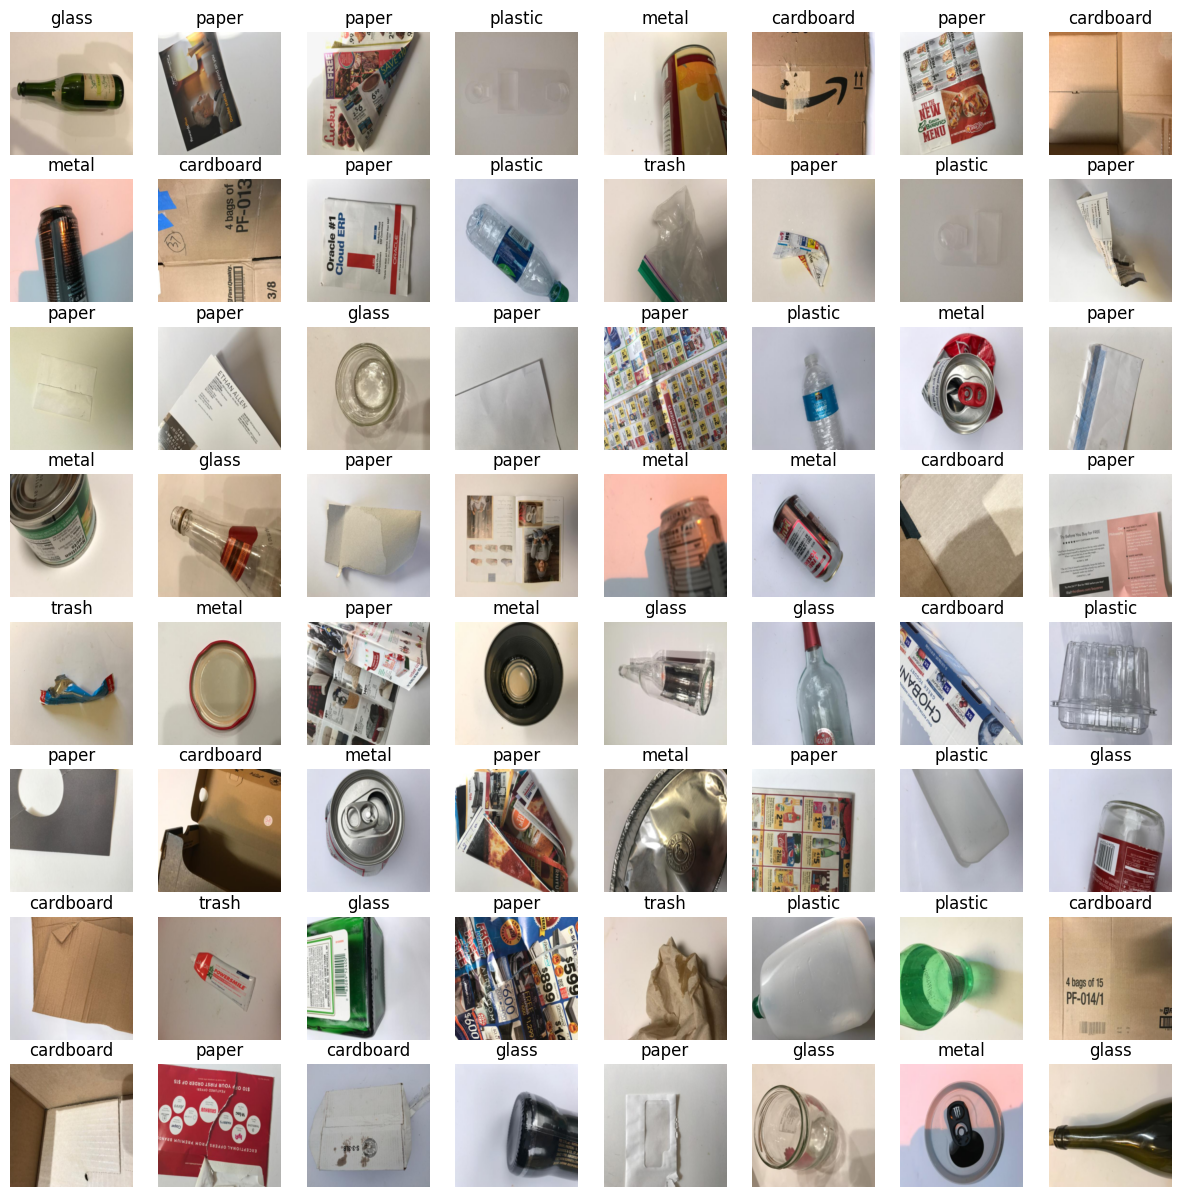

In [ ]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

In [ ]:
def train(net, num_epochs, lr, momentum):

  # Specify a folder under run for tensorboard data for the training

  writer = SummaryWriter("runs/lr_1")
  device = torch.device('cuda:0')

  net = net.to(device)

  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

  train_losses = []

  for i in range(num_epochs):

      loss_total = 0
      loss_val = 0
      acc_train = 0
      total_train = 0

      for ii, batch in enumerate(train_loader):

          data = batch[0]
          label = batch[1]
          optimizer.zero_grad()
          data, label = data.to(device), label.to(device)
          logits = net(data)
          if isinstance(logits, tuple):  # If the model returns a tuple
            logits = logits[0]
          else:  # If the model returns a single tensor
            logits = logits
          loss = F.cross_entropy(logits, label)
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
          out = torch.argmax(logits, dim=1)
          acc_train += torch.sum(out == label)
          total_train += logits.shape[0]

      train_loss_avg = loss_total / ii
      train_acc_avg = acc_train.item() / total_train
      train_losses.append(train_loss_avg)
      lr_scheduler.step()

      if i % 2 == 0:
        print(f"Epoch {i}: Training Loss: {train_loss_avg}")
        print(f"Epoch {i}: Training Accuracy: {train_acc_avg}")


      writer.add_scalar('Loss/train', train_loss_avg, i)
      writer.add_scalar('Accuracy/train', train_acc_avg, i)

  print(f"Final Training Loss: {train_loss_avg}")
  print(f"Final Training Accuracy: {train_acc_avg}")

  # Plot the data
  plt.plot(train_losses, label='Training Set')

  # Add legend
  plt.legend()

  # Add title and labels
  plt.title('Loss vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the graph
  plt.show()

  return train_losses


In [ ]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0: Training Loss: 1.1827246316017643
Epoch 0: Training Accuracy: 0.6241345202769535
Epoch 2: Training Loss: 0.41997175351265936
Epoch 2: Training Accuracy: 0.8625123639960435
Epoch 4: Training Loss: 0.0892339768188615
Epoch 4: Training Accuracy: 0.9688427299703264
Epoch 6: Training Loss: 0.014504323292884135
Epoch 6: Training Accuracy: 0.9990108803165183
Epoch 8: Training Loss: 0.005861171941843725
Epoch 8: Training Accuracy: 0.9990108803165183
Epoch 10: Training Loss: 0.004419634997424099
Epoch 10: Training Accuracy: 0.9990108803165183
Epoch 12: Training Loss: 0.004463366182115409
Epoch 12: Training Accuracy: 0.9990108803165183
Epoch 14: Training Loss: 0.005234836974376512
Epoch 14: Training Accuracy: 0.9980217606330366
Epoch 16: Training Loss: 0.0030678471310004113
Epoch 16: Training Accuracy: 0.9990108803165183
Epoch 18: Training Loss: 0.0026504568748116015
Epoch 18: Training Accuracy: 0.9995054401582592
Final Training Loss: 0.0037352063584201517
Final Training Accuracy: 0.998

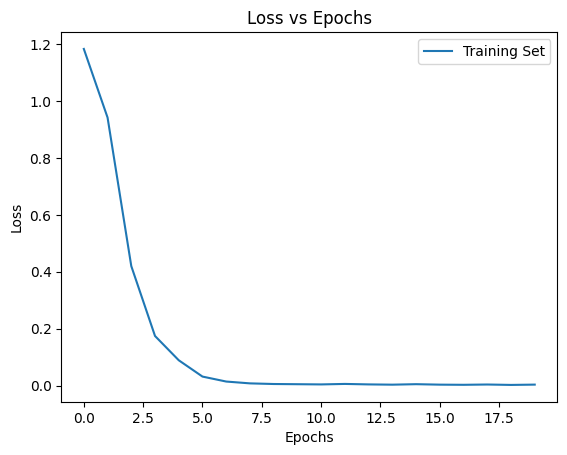

[1.1827246316017643,
 0.9417646286949035,
 0.41997175351265936,
 0.1745189198803517,
 0.0892339768188615,
 0.03195449358393108,
 0.014504323292884135,
 0.008087659461213457,
 0.005861171941843725,
 0.0051417172841367225,
 0.004419634997424099,
 0.006137707050994879,
 0.004463366182115409,
 0.003543032078831006,
 0.005234836974376512,
 0.003599954780281311,
 0.0030678471310004113,
 0.0040961391247448424,
 0.0026504568748116015,
 0.0037352063584201517]

In [ ]:
train(net, 20, 2e-2, 0.9)

In [ ]:
def test(net):

  device = torch.device('cuda:0')
  net = net.to(device)
  net.eval()
  with torch.no_grad():
    total_loss = 0
    acc_test = 0
    total_test = 0
    for batch in test_loader:
      data = batch[0]
      label = batch[1]
      data, label = data.to(device), label.to(device)
      logits = net(data)
      if isinstance(logits, tuple):  # If the model returns a tuple
        logits = logits[0]
      else:  # If the model returns a single tensor
        logits = logits
      loss = F.cross_entropy(logits, label)
      total_loss += loss.item()
      out = torch.argmax(logits, dim=1)
      acc_test += torch.sum(out == label)
      total_test += logits.shape[0]

    print(f"Testing Loss: {total_loss/len(test_loader)}")
    print(f"Testing Accuracy: {acc_test/total_test}")

In [ ]:
test(net)

Testing Loss: 0.31137864105403423
Testing Accuracy: 0.9188119173049927
